In [8]:
import optuna
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

from xgboost import XGBClassifier

import joblib

In [9]:
# 1 Load Dataset

df = pd.read_csv("Dataset/Cleaned.csv")

X = df.drop(columns=["NSP", "CLASS"])

y = df["NSP"] -1 # Doing this now so no wrapper is necessary as this only trains an XGBoost Model

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

X_train.shape, X_test.shape

((1700, 21), (426, 21))

In [10]:
# 2 Optuna Hyperparameter Search

def objective(trial):

    params = {
        "objective": "multi:softprob",
        "num_class": 3,
        "eval_metric": "mlogloss",
        "tree_method": "hist",   # Faster
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "gamma": trial.suggest_float("gamma", 0.0, 5.0),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.0, 5.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 5.0),
        "n_estimators": trial.suggest_int("n_estimators", 200, 1500)
    }

    model = XGBClassifier(**params)

    model.fit(
        X_train, y_train,
        eval_set=[(X_test, y_test)],
        verbose=False,
    )

    preds = model.predict(X_test)
    macro_f1 = f1_score(y_test, preds, average="macro")
    
    return macro_f1

In [11]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

print("Best Trial:")
print(study.best_trial.params)

[I 2025-12-01 18:39:06,091] A new study created in memory with name: no-name-c119b993-8bb7-4a62-94c4-2c423477c428
[I 2025-12-01 18:39:06,868] Trial 0 finished with value: 0.7927891612010916 and parameters: {'learning_rate': 0.13007298073801982, 'max_depth': 8, 'min_child_weight': 5, 'gamma': 3.3454744643209375, 'subsample': 0.5648464996807216, 'colsample_bytree': 0.7069262538616045, 'reg_lambda': 1.5070830655920937, 'reg_alpha': 4.573687239516408, 'n_estimators': 1497}. Best is trial 0 with value: 0.7927891612010916.
[I 2025-12-01 18:39:07,181] Trial 1 finished with value: 0.8294751378667994 and parameters: {'learning_rate': 0.129475710309947, 'max_depth': 6, 'min_child_weight': 8, 'gamma': 2.262154907199613, 'subsample': 0.9700326078637922, 'colsample_bytree': 0.5479864108315526, 'reg_lambda': 2.4666803509413433, 'reg_alpha': 3.798627121250836, 'n_estimators': 665}. Best is trial 1 with value: 0.8294751378667994.
[I 2025-12-01 18:39:07,637] Trial 2 finished with value: 0.8882756267051

Best Trial:
{'learning_rate': 0.08299180724721404, 'max_depth': 6, 'min_child_weight': 2, 'gamma': 0.6989417932145896, 'subsample': 0.917172921653297, 'colsample_bytree': 0.9429279554021012, 'reg_lambda': 1.450643364220737, 'reg_alpha': 0.5370952536159892, 'n_estimators': 859}


In [12]:
# 3 Create model based on Optuna's Search

best_params = study.best_trial.params

best_model = XGBClassifier(
    objective="multi:softprob",
    num_class=3,
    eval_metric="mlogloss",
    tree_method="hist",
    **best_params
)

best_model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=False,
)

,objective,'multi:softprob'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.9429279554021012
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'mlogloss'


Final Accuracy: 0.9553990610328639
Final Macro F1: 0.9150072150072149

Classification Report:
              precision    recall  f1-score   support

         1.0       0.96      0.99      0.98       332
         2.0       0.92      0.80      0.85        59
         3.0       0.91      0.91      0.91        35

    accuracy                           0.96       426
   macro avg       0.93      0.90      0.92       426
weighted avg       0.95      0.96      0.95       426



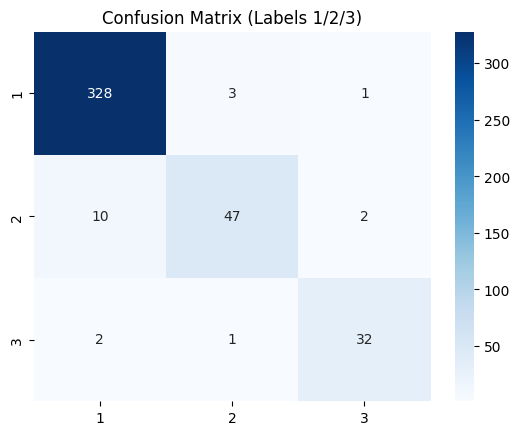

In [13]:
# 4 Evaluate Model and Print Confusion Matrix

preds = best_model.predict(X_test)

preds_original = preds + 1
y_test_original = y_test + 1

macro_f1 = f1_score(y_test_original, preds_original, average="macro")
acc = accuracy_score(y_test_original, preds_original)

print("Final Accuracy:", acc)
print("Final Macro F1:", macro_f1)

print("\nClassification Report:")
print(classification_report(y_test_original, preds_original))

labels = [1, 2, 3]
cm = confusion_matrix(y_test_original, preds_original, labels=labels)
sns.heatmap(cm, annot=True, fmt="g", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix (Labels 1/2/3)")
plt.show()

In [14]:
# 5 Save Model

joblib.dump(best_model, "Models/xgb_3class_tuned.pkl")

['Models/xgb_3class_tuned.pkl']